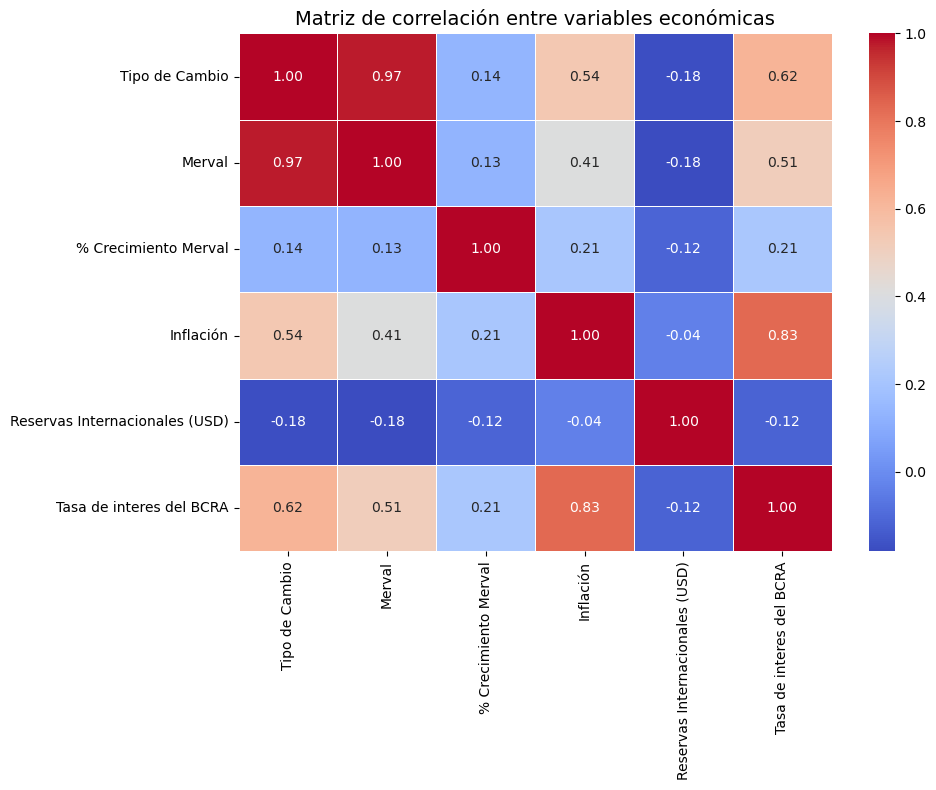

            Tipo de Cambio     Merval  % Crecimiento Merval  Inflación  \
Fecha                                                                    
2000-01-31             1.0  566.28003              2.872102        0.8   
2000-02-29             1.0  631.64001             11.541989        0.0   
2000-03-31             1.0  569.03998             -9.910713       -0.5   
2000-04-30             1.0  509.51001            -10.461474       -0.1   
2000-05-31             1.0  464.29999             -8.873235       -0.4   

            Reservas Internacionales (USD)  Tasa de interes del BCRA  
Fecha                                                                 
2000-01-31                             NaN                  2.936637  
2000-02-29                             NaN                  2.962181  
2000-03-31                             NaN                  2.938539  
2000-04-30                             NaN                  2.896833  
2000-05-31                             NaN             

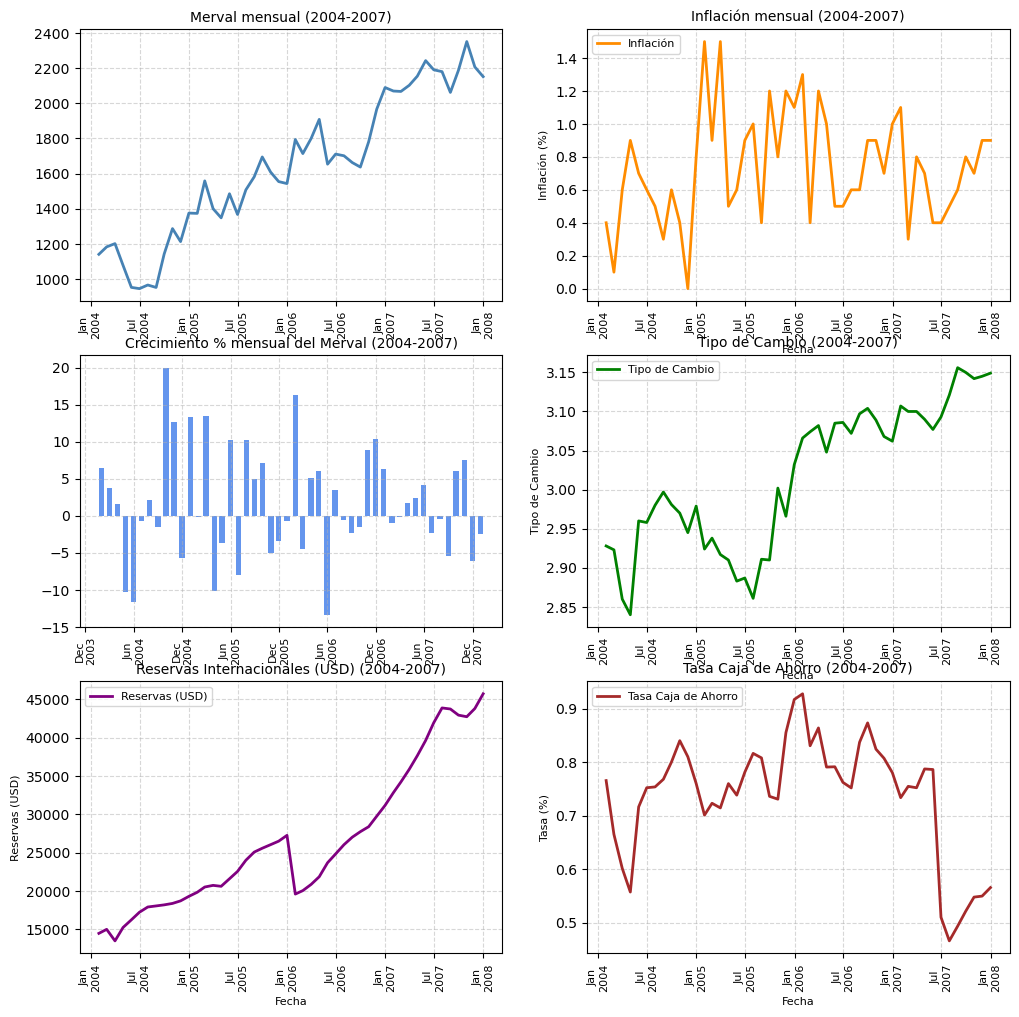

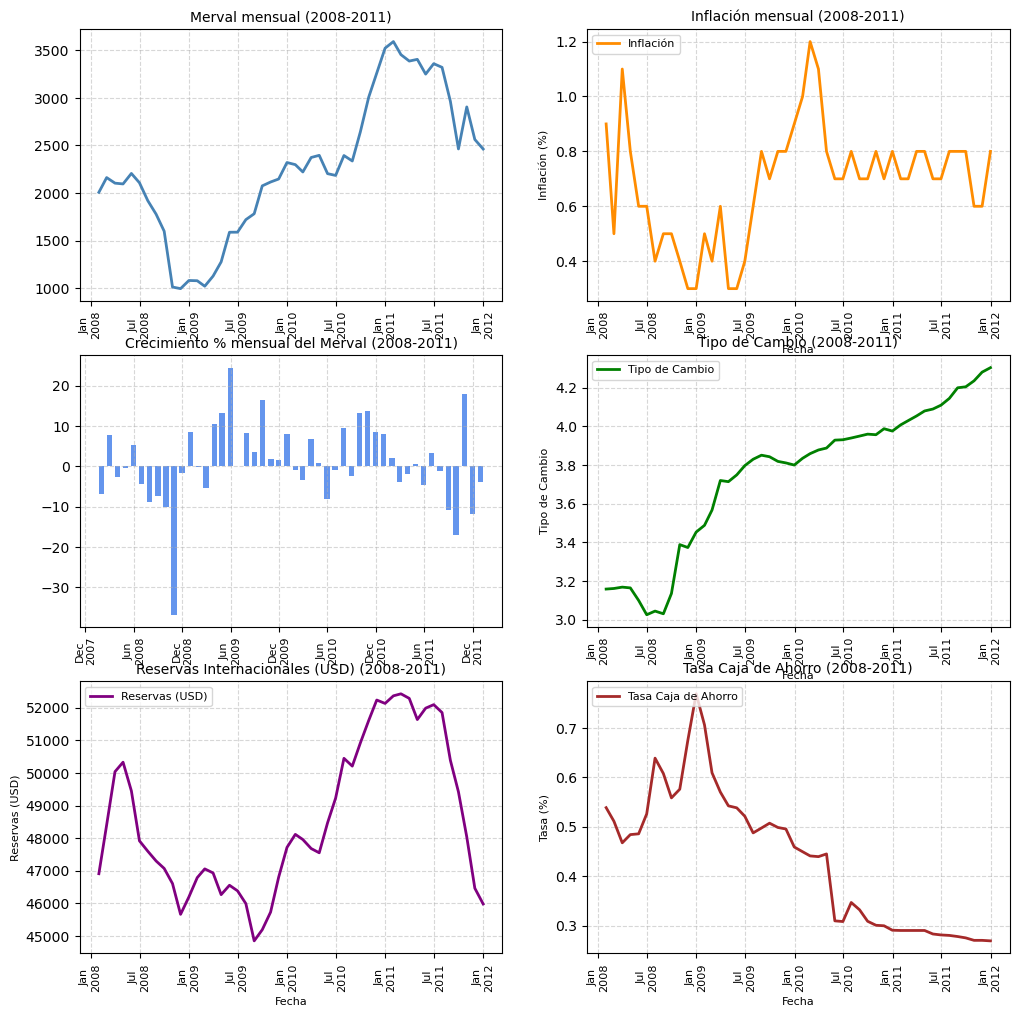

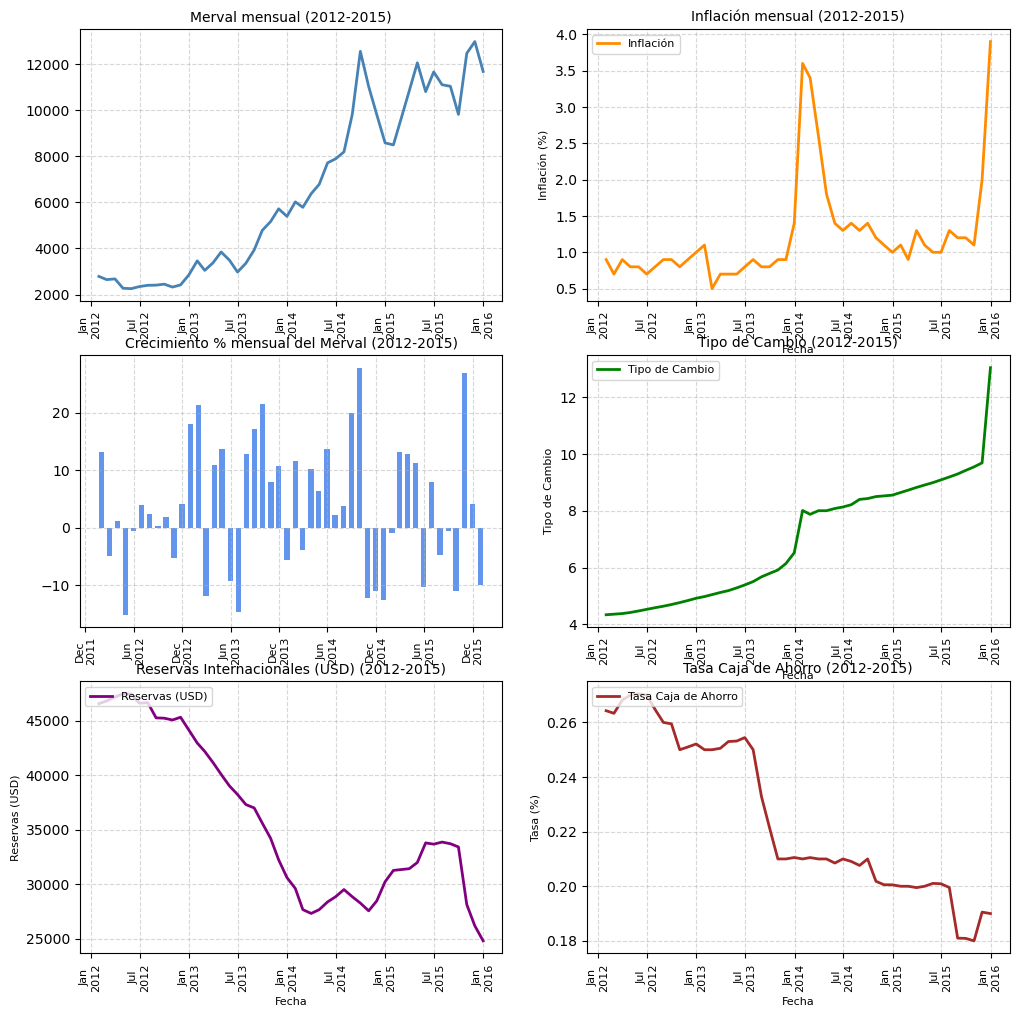

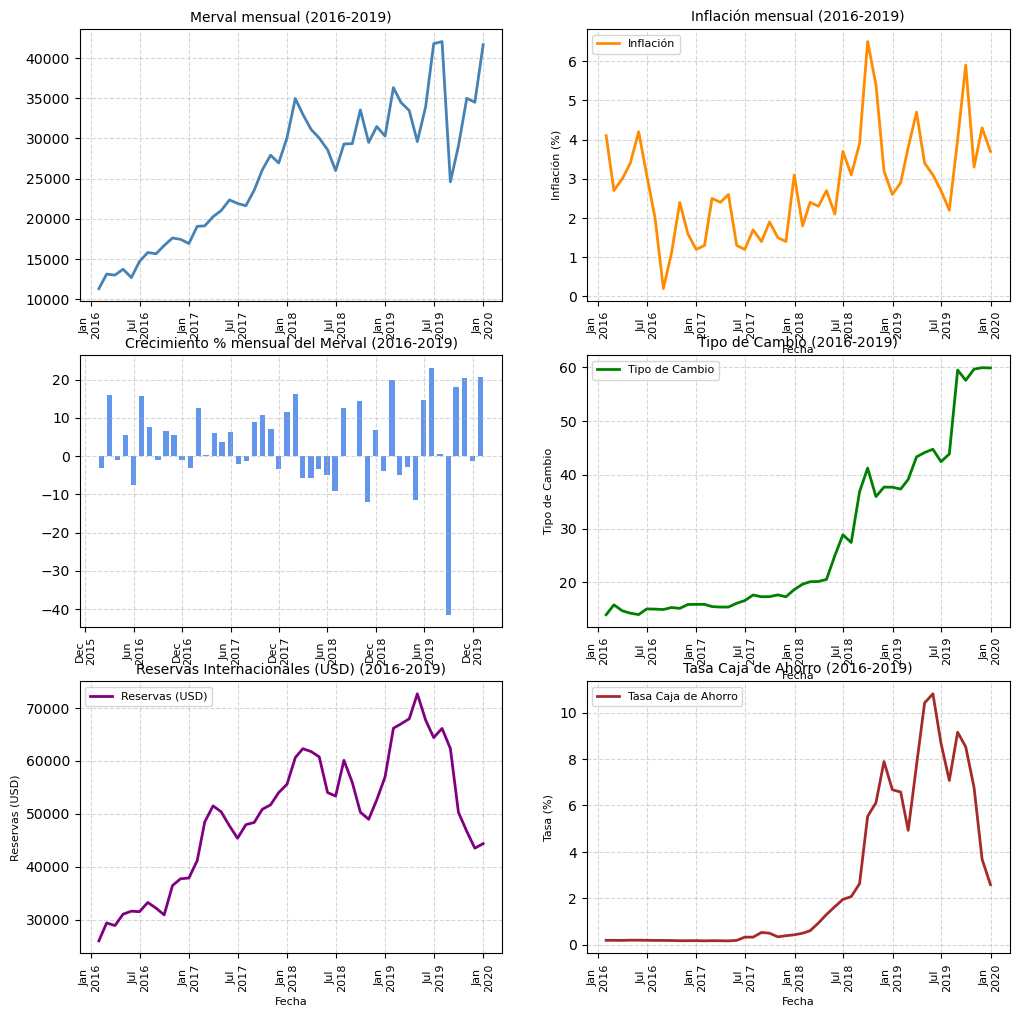

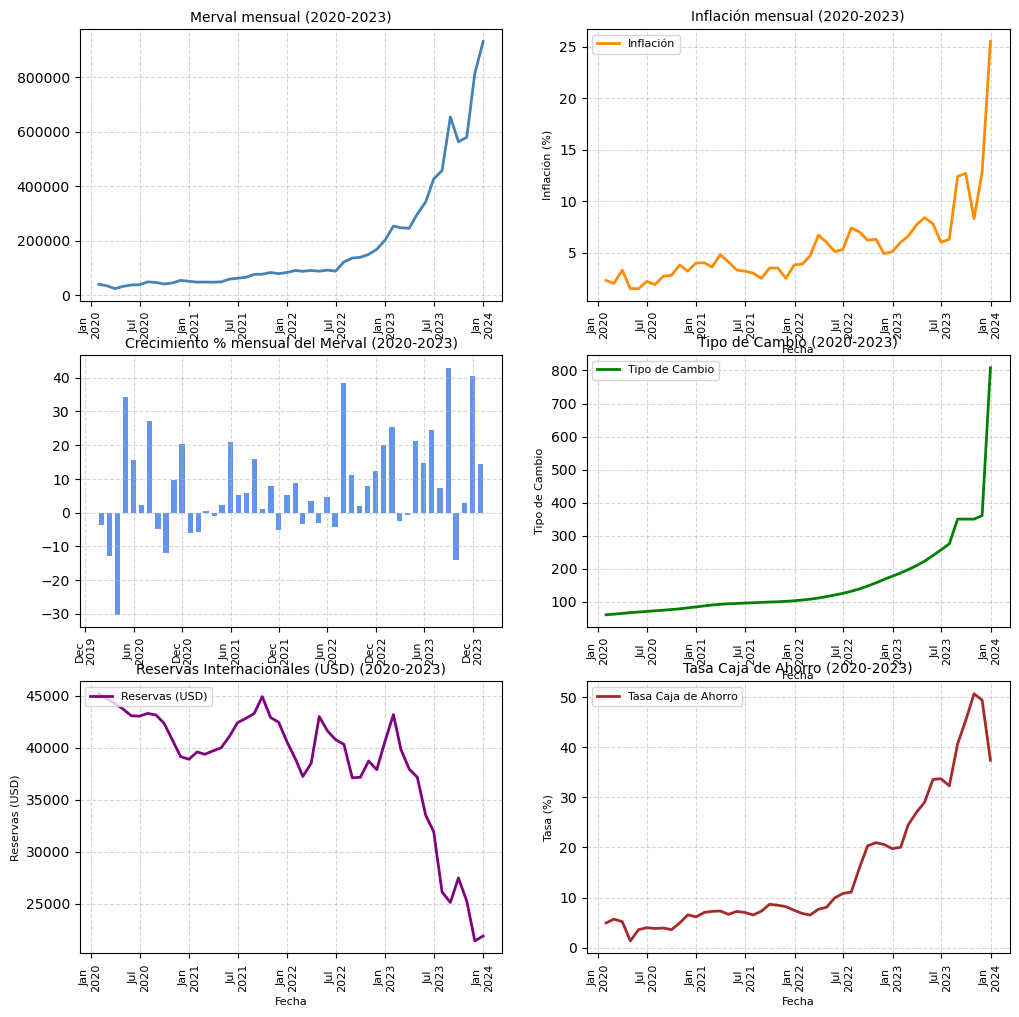

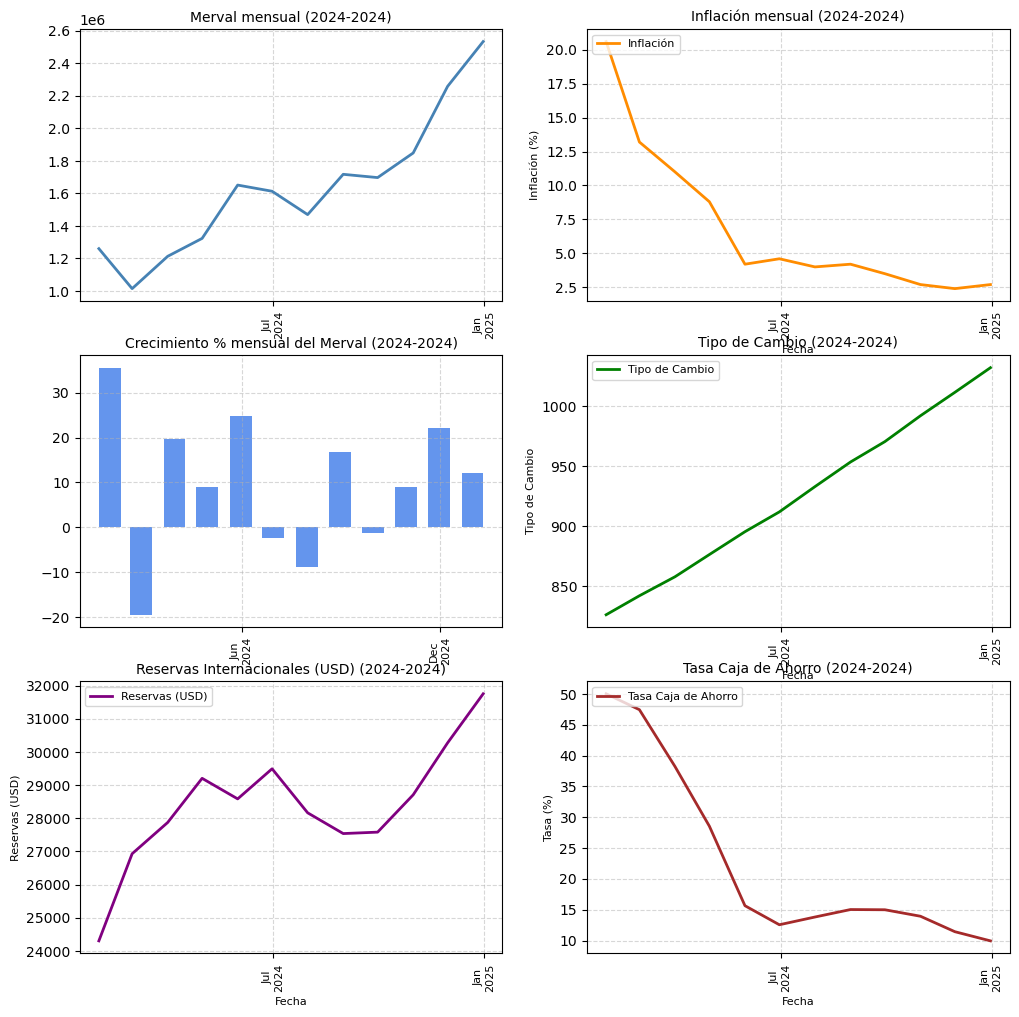

In [24]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# --- Lectura de archivos principales ---
dolar_df = pd.read_csv("tipos-de-cambio-historicos.csv")
inflacion_df = pd.read_excel("inflacion.xlsx")
merval_df = pd.read_csv("MERVAL - Cotizaciones historicas.csv")

def standardize_date_column(df, possible_columns):
    """Busca y renombra la columna de fecha a 'Fecha' si la encuentra."""
    for col in possible_columns:
        if col in df.columns:
            df['Fecha'] = pd.to_datetime(df[col], errors='coerce')
            return df
    print(f"Advertencia: No se encontró una columna de fecha estándar en el DataFrame. Columnas presentes: {df.columns}")
    return df

# --- Estandarización de columnas de fecha ---
dolar_df = standardize_date_column(dolar_df, ['indice_tiempo', 'Fecha'])
inflacion_df = standardize_date_column(inflacion_df, ['indice_tiempo', 'Fecha'])
merval_df = standardize_date_column(merval_df, ['fecha', 'Fecha']) # Buscamos 'fecha' primero

# --- Reparar CSV del Merval (si es necesario) ---
if merval_df.shape[1] == 1 and "," in merval_df.columns[0]:
    raw = pd.read_csv("MERVAL - Cotizaciones historicas.csv", header=None)
    merval_df = raw[0].str.split(",", expand=True)
    merval_df.columns = raw.iloc[0].tolist() # Usamos la primera fila del raw para los nombres
    merval_df = merval_df.drop(index=0).reset_index(drop=True)
    merval_df = standardize_date_column(merval_df, ['fecha', 'Fecha']) # Volvemos a estandarizar después de la reparación
else:
    merval_df = standardize_date_column(merval_df, ['fecha', 'Fecha']) # Si no necesita reparación, buscamos 'fecha'

# --- Unificación de tipos de cambio ---
columnas_dolar = [
    'dolar_tipo_unico', 'dolar_finan_esp_compra', 'dolar_finan_esp_venta',
    'dolar_financiero_compra', 'dolar_financiero_venta',
    'dolar_libre_compra', 'dolar_libre_venta',
    'dolar_oficial_compra', 'dolar_oficial_venta',
    'dolar_estadounidense', 'dolar_referencia_com_3500'
]
if 'tipo_cambio_unificado' not in dolar_df.columns:
    dolar_df['tipo_cambio_unificado'] = dolar_df[columnas_dolar].bfill(axis=1).iloc[:, 0]

# --- Unir DataFrames por 'Fecha' ---
dataframes_a_unir = {'dolar_df': dolar_df, 'merval_df': merval_df, 'inflacion_df': inflacion_df}
for name, df in dataframes_a_unir.items():
    if 'Fecha' in df.columns:
        df.set_index('Fecha', inplace=True)
    else:
        print(f"Error: El DataFrame '{name}' no tiene la columna 'Fecha' para establecer como índice.")

# --- Unir DataFrames (temporalmente con inner para ver la intersección) ---
df_combinado_diario = pd.concat([dataframes_a_unir['dolar_df'][['tipo_cambio_unificado']], dataframes_a_unir['merval_df'][['cierre']]], axis=1, join='inner')
df_combinado_diario = df_combinado_diario.merge(dataframes_a_unir['inflacion_df'][['inflacion']], left_index=True, right_index=True, how='inner')
df_combinado_diario.reset_index(inplace=True)
df_combinado_diario.rename(columns={'index': 'Fecha'}, inplace=True)
df_combinado_diario.set_index('Fecha', inplace=True)

# --- Leer archivos económicos adicionales ---
ruta_carpeta = "D:/Mis documentos/Estudio/Lic en economia/2do Año/Big data & machine learning/Tps/TP Grupal"
archivos = [
    "principales-tasas-interes-referencia-principales-economias-mundo-frecuencia-mensual.csv",
    "reservas-internacionales-pasivos-financieros-bcra.csv",
    "principales-tasas-interes.csv"
]
rutas = [os.path.join(ruta_carpeta, f) for f in archivos]
df_filtrado = pd.concat([pd.read_csv(r) for r in rutas], ignore_index=True)

# --- Filtrar columnas útiles ---
columnas_utiles_economico = [
    'indice_tiempo', 'reservas_internacionales_dolares'
]
df_economico = pd.DataFrame()
if 'indice_tiempo' in df_filtrado.columns:
    df_economico_reservas = df_filtrado[df_filtrado['indice_tiempo'].notna()][columnas_utiles_economico].copy()
    df_economico_reservas['Fecha'] = pd.to_datetime(df_economico_reservas['indice_tiempo'], errors='coerce')
    df_economico_reservas.set_index('Fecha', inplace=True)
else:
    print("Advertencia: La columna 'indice_tiempo' no se encontró en df_filtrado para reservas.")

# --- Leer el archivo de tasas de interés por separado ---
ruta_tasas = os.path.join(ruta_carpeta, "principales-tasas-interes.csv")
try:
    df_tasas = pd.read_csv(ruta_tasas)
    if 'indice_tiempo' in df_tasas.columns and 'tasas_interes_cajas_ahorro' in df_tasas.columns:
        df_tasas_caja_ahorro = df_tasas[['indice_tiempo', 'tasas_interes_cajas_ahorro']].copy()
        df_tasas_caja_ahorro['Fecha'] = pd.to_datetime(df_tasas_caja_ahorro['indice_tiempo'], errors='coerce')
        df_tasas_caja_ahorro.set_index('Fecha', inplace=True)
    else:
        print("Advertencia: No se encontraron las columnas 'indice_tiempo' o 'tasas_interes_cajas_ahorro' en el archivo de tasas.")
        df_tasas_caja_ahorro = pd.DataFrame(index=inflacion_df.resample('ME').last().index) # DataFrame vacío con índice de inflación
except FileNotFoundError:
    print(f"Advertencia: No se encontró el archivo '{ruta_tasas}'.")
    df_tasas_caja_ahorro = pd.DataFrame(index=inflacion_df.resample('ME').last().index) # DataFrame vacío con índice de inflación

# --- Remuestrear todos los DataFrames a frecuencia mensual ---
dolar_mensual_df = dolar_df[['tipo_cambio_unificado']].resample('ME').last()
merval_mensual_df = merval_df[['cierre']].resample('ME').last()
inflacion_mensual_df = inflacion_df[['inflacion']].resample('ME').last()
reservas_mensual_df = df_economico_reservas.resample('ME').last()
tasas_caja_ahorro_mensual_df = df_tasas_caja_ahorro.resample('ME').last()

# --- Calcular el crecimiento porcentual del Merval mensual ---
merval_mensual_df['crecimiento_pct'] = merval_mensual_df['cierre'].pct_change() * 100


# --- Unir todos los DataFrames mensuales ---
df_combinado_mensual = pd.concat([dolar_mensual_df, merval_mensual_df, inflacion_mensual_df, reservas_mensual_df, tasas_caja_ahorro_mensual_df], axis=1, join='inner')
df_combinado_mensual.reset_index(inplace=True)
df_combinado_mensual.rename(columns={'index': 'Fecha'}, inplace=True)
df_combinado_mensual.set_index('Fecha', inplace=True)

df_combinado_mensual.rename(columns={
    'tipo_cambio_unificado': 'Tipo de Cambio',
    'cierre': 'Merval',
    'crecimiento_pct': '% Crecimiento Merval',
    'inflacion': 'Inflación',
    'reservas_internacionales_dolares': 'Reservas Internacionales (USD)',
    'tasas_interes_cajas_ahorro': 'Tasa de interes del BCRA'
}, inplace=True)



# --- Heatmap de correlación ---
plt.figure(figsize=(10, 8))
# Usamos solo columnas numéricas
correlation_matrix = df_combinado_mensual[['Tipo de Cambio', 'Merval', '% Crecimiento Merval', 'Inflación', 'Reservas Internacionales (USD)', 'Tasa de interes del BCRA']].astype(float).corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación entre variables económicas", fontsize=14)
plt.tight_layout()
plt.show()


# --- Resultado final ---
print(df_combinado_mensual[['Tipo de Cambio', 'Merval', '% Crecimiento Merval', 'Inflación', 'Reservas Internacionales (USD)', 'Tasa de interes del BCRA']].head())
print(df_combinado_mensual.columns)

# Definir periodos de 4 años desde 2004
start_year = 2004
end_year = 2024
periodos = [(y, min(y + 3, end_year)) for y in range(start_year, end_year + 1, 4)]

# Crear una figura por cada periodo
for start, end in periodos:
    start_date = pd.Timestamp(f'{start}-01-01')
    end_date = pd.Timestamp(f'{end}-12-31')
    df_slice = df_combinado_mensual[(df_combinado_mensual.index >= start_date) & (df_combinado_mensual.index <= end_date)].copy() # Usamos .copy() para evitar SettingWithCopyWarning

    if df_slice.empty:
        continue

    # Verificar las columnas en df_slice antes de graficar
    print(f"Columnas disponibles en df_slice ({start}-{end}): {df_slice.columns.tolist()}")

    # Crear una figura con 3 filas y 2 columnas para los 6 gráficos
    fig, axs = plt.subplots(3, 2, figsize=(12, 12))  # 3x2 grid

    # --- Gráfico 1: Merval mensual ---
    axs[0, 0].plot(df_slice.index, df_slice['Merval'], color='steelblue', linewidth=2)
    axs[0, 0].set_title(f'Merval mensual ({start}-{end})', fontsize=10)
    axs[0, 0].grid(True, linestyle='--', alpha=0.5)
    axs[0, 0].tick_params(axis='x', labelrotation=90, labelsize=8)
    axs[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axs[0, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))

    # --- Gráfico 2: Crecimiento % mensual del Merval ---
    if '% Crecimiento Merval' in df_slice.columns:
        axs[1, 0].bar(df_slice.index, df_slice['% Crecimiento Merval'], color='cornflowerblue', width=20)
        axs[1, 0].set_title(f'Crecimiento % mensual del Merval ({start}-{end})', fontsize=10)
        axs[1, 0].grid(True, linestyle='--', alpha=0.5)
        axs[1, 0].tick_params(axis='x', labelrotation=90, labelsize=8)
        axs[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
        axs[1, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    else:
        print(f"Advertencia: La columna '% Crecimiento Merval' no está presente en el periodo ({start}-{end})")

    # --- Gráfico 3: Inflación mensual ---
    axs[0, 1].plot(df_slice.index, df_slice['Inflación'], color='darkorange', label='Inflación', linewidth=2)
    axs[0, 1].set_title(f'Inflación mensual ({start}-{end})', fontsize=10)
    axs[0, 1].set_xlabel('Fecha', fontsize=8)
    axs[0, 1].set_ylabel('Inflación (%)', fontsize=8)
    axs[0, 1].grid(True, linestyle='--', alpha=0.5)
    axs[0, 1].tick_params(axis='x', labelrotation=90, labelsize=8)
    axs[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axs[0, 1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axs[0, 1].legend(loc='upper left', fontsize=8)

    # --- Gráfico 4: Tipo de Cambio Unificado mensual ---
    axs[1, 1].plot(df_slice.index, df_slice['Tipo de Cambio'], color='green', label='Tipo de Cambio', linewidth=2)
    axs[1, 1].set_title(f'Tipo de Cambio ({start}-{end})', fontsize=10)
    axs[1, 1].set_xlabel('Fecha', fontsize=8)
    axs[1, 1].set_ylabel('Tipo de Cambio', fontsize=8)
    axs[1, 1].grid(True, linestyle='--', alpha=0.5)
    axs[1, 1].tick_params(axis='x', labelrotation=90, labelsize=8)
    axs[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axs[1, 1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axs[1, 1].legend(loc='upper left', fontsize=8)

    # --- Gráfico 5: Reservas Internacionales (USD) mensual ---
    if 'Reservas Internacionales (USD)' in df_slice.columns:
        axs[2, 0].plot(df_slice.index, df_slice['Reservas Internacionales (USD)'], color='purple', label='Reservas (USD)', linewidth=2)
        axs[2, 0].set_title(f'Reservas Internacionales (USD) ({start}-{end})', fontsize=10)
        axs[2, 0].set_xlabel('Fecha', fontsize=8)
        axs[2, 0].set_ylabel('Reservas (USD)', fontsize=8)
        axs[2, 0].grid(True, linestyle='--', alpha=0.5)
        axs[2, 0].tick_params(axis='x', labelrotation=90, labelsize=8)
        axs[2, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
        axs[2, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        axs[2, 0].legend(loc='upper left', fontsize=8)
    else:
        print(f"Advertencia: La columna 'Reservas Internacionales (USD)' no está presente en el periodo ({start}-{end})")

    # --- Gráfico 6: Tasa de Interés Cajas de Ahorro mensual ---
    if 'Tasa de interes del BCRA' in df_slice.columns:
        axs[2, 1].plot(df_slice.index, df_slice['Tasa de interes del BCRA'], color='brown', label='Tasa Caja de Ahorro', linewidth=2)
        axs[2, 1].set_title(f'Tasa Caja de Ahorro ({start}-{end})', fontsize=10)
        axs[2, 1].set_xlabel('Fecha', fontsize=8)
        axs[2, 1].set_ylabel('Tasa (%)', fontsize=8)
        axs[2, 1].grid(True, linestyle='--', alpha=0.5)
        axs[2, 1].tick_params(axis='x', labelrotation=90, labelsize=8)
        axs[2, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
        axs[2, 1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        axs[2, 1].legend(loc='upper left', fontsize=8)
    else:
        print(f"Advertencia: La columna 'Tasa de interes del BCRA' no está presente en el periodo ({start}-{end})")

    # ---